Group 20 members:
- Janick Michot:          michojan@students.zhaw.ch
- Andre von Aarburg :     andre.vonaarbrug@ost.ch
- Manuel Weiss:           weissman@students.zhaw.ch

In [126]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

## Binary Classification

Here, we use a tabular dataset from kaggle (https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) with features on patients physical spine details possibly suited for classifying whether the person is 'abnormal' or 'normal' - possibly suffers back pain or not.   

We here just want to see how the training works with logistic regression (binary case). We set aside a proper handling of the learning experiment by splitting the data into a train and test partition (in general we would even have a validation partition). We focus here on making the system learn something. 

### Load Data

In [35]:
import pandas as pd
df = pd.read_csv("./Dataset_spine.csv") # possibly modify!
df = df.drop(columns=['Unnamed: 13'])
N  = df.shape[0]
print("df shape: ", df.shape)
df.head()

df shape:  (310, 13)


,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


tensor(0.5000)


### Normalization and Turning into Torch Tensors

In [36]:
x0 = torch.from_numpy(df.values[:,0:-1].astype(np.float64))
X = (x0-torch.mean(x0, dim=0))/torch.std(x0,dim=0)
Y = torch.tensor(('Abnormal'==df.values[:,-1])).int().reshape(-1,1)

print(X[:5, :])
print(Y[:5, :])
print(X.shape, Y.shape)

tensor([[ 0.1468,  0.5006, -0.6641, -0.1847, -1.4453, -0.7069,  0.9501, -1.0134,
          0.4336,  1.1652, -1.1947,  1.7096],
        [-1.2439, -0.7476, -1.4507, -1.0398, -0.2640, -0.5786, -0.2022, -0.9762,
          1.3142,  1.6768, -0.9388, -0.9125],
        [ 0.4836,  0.4672, -0.0991,  0.2726, -0.8962, -0.7941,  0.0067,  0.6381,
          1.3006,  1.6333, -1.2252, -0.6147],
        [ 0.5106,  0.7104, -0.4107,  0.1259, -1.2054, -0.4016, -0.3626,  0.2591,
         -0.1050, -0.1759, -1.3428, -0.6519],
        [-0.6256, -0.7884, -1.2727, -0.2155, -0.7323, -0.4893,  0.2463,  1.6404,
          0.8501, -1.0580, -0.1902, -0.0697]], dtype=torch.float64)
tensor([[1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32)
torch.Size([310, 12]) torch.Size([310, 1])


### (Binary) Logistic Regression

Data:  $\,\qquad X = \left(\begin{array}{cccc} 1 & X_{11} & \dots & X_{1n} \\ \vdots & \vdots & \vdots & \vdots \\ 1 & X_{N1} & \dots & X_{Nn}\end{array}\right)\qquad$ and $\qquad Y = \left(\begin{array}{c} Y_{1} \\ \vdots \\ Y_{N} \end{array}\right)$

Model: $\qquad\hat{Y}(X;W) = \sigma\left(X W^\intercal\right) \qquad$ where $\qquad W = \left(\begin{array}{c} W_0 \\ W_1 \\ \vdots \\ W_n \end{array}\right)$

The model outputs the probability of observing in a sample $x$ a '1' (Abnormal).

Cost:  $\,\qquad C(W) = -\frac{1}{N}\sum_j \left(Y_j\log(\hat{Y}_j(X;W)) + (1-Y_j)\log(1-\hat{Y}_j(X;W))\right)$

__Remark:__ Note that the logarithm diverges at arguments approaching 0. Make sure that you don't run into numerical issues.

In [37]:
# compose torch tensors X of shape (N,13) by inserting a column with 1's as first column  
X = torch.cat((torch.ones(N,1),X), dim=1)
print(X[:5,:])

tensor([[ 1.0000,  0.1468,  0.5006, -0.6641, -0.1847, -1.4453, -0.7069,  0.9501,
         -1.0134,  0.4336,  1.1652, -1.1947,  1.7096],
        [ 1.0000, -1.2439, -0.7476, -1.4507, -1.0398, -0.2640, -0.5786, -0.2022,
         -0.9762,  1.3142,  1.6768, -0.9388, -0.9125],
        [ 1.0000,  0.4836,  0.4672, -0.0991,  0.2726, -0.8962, -0.7941,  0.0067,
          0.6381,  1.3006,  1.6333, -1.2252, -0.6147],
        [ 1.0000,  0.5106,  0.7104, -0.4107,  0.1259, -1.2054, -0.4016, -0.3626,
          0.2591, -0.1050, -0.1759, -1.3428, -0.6519],
        [ 1.0000, -0.6256, -0.7884, -1.2727, -0.2155, -0.7323, -0.4893,  0.2463,
          1.6404,  0.8501, -1.0580, -0.1902, -0.0697]], dtype=torch.float64)


In [38]:
# implement methods for predicting the probability of having label 0 or 1 (W with shape (1,13))
def predict(X,W):
    # YOUR CODE (START)
    return torch.sigmoid(X@W.T)
    # YOUR CODE (END)

def cost(X,Y,W):
    # YOUR CODE (START)
    Yhat = predict(X, W)
    return -(1/N)*(torch.sum(torch.log(Yhat[Y==1]))+torch.sum(torch.log(1-Yhat[Y==0])))
    # YOUR CODE (END)

In [94]:
def gradient_cost(X,Y,W):
    # YOUR CODE (START)
    Yhat = predict(X, W)
    return -(Y-Yhat).T@X/N
    # YOUR CODE (END)
    
def accuracy(Y,Yhat):
    # YOUR CODE (START)
    return ((sum((Y==torch.round(Yhat)).int()))/N).item()
    # YOUR CODE (END)

Just for testing:

In [159]:
W = torch.randn((1,13), dtype=torch.double)
print(predict(X[0],W))
print(cost(X,Y,W))
print(gradient_cost(X,Y,W))
print(accuracy(Y,predict(X,W)))

tensor([0.0989], dtype=torch.float64)
tensor(1.3321, dtype=torch.float64)
tensor([[-3.1143e-01, -1.8297e-03,  1.7836e-04,  2.8013e-02, -2.4824e-03,
          2.0895e-01, -3.8303e-02,  9.4155e-02,  1.9426e-02,  2.1341e-01,
         -5.8543e-02,  4.2729e-02, -1.2563e-02]], dtype=torch.float64)
0.5451613068580627


### Training

Training Accuracy (max,end): 0.874194, 0.854839
Training Cost (end): 0.284133


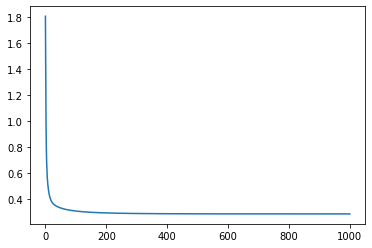

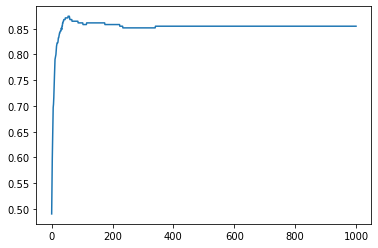

In [161]:
# adjust if needed
nepochs = 1000
lr = 1.0

## initial parameter
W = torch.randn((1,13), dtype=torch.double)

# track the costs
costs = [cost(X,Y,W)]
accs = [accuracy(Y,predict(X,W))]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    W = W - lr * gradient_cost(X, Y, W)
    costs.append(cost(X,Y,W))
    accs.append(accuracy(Y,predict(X,W)))

# YOUR CODE (END)
    
# some output
accs = np.array(accs)

print("Training Accuracy (max,end): %f, %f"%(np.max(accs), accs[-1]))
print("Training Cost (end): %f"%costs[-1].item())
plt.figure(1)
plt.plot(range(nepochs+1),costs)
plt.figure(2)
plt.plot(range(nepochs+1),accs)
plt.show()

### Different Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

In [158]:
decent_limit = 1 * 10**-4
nepochs = 10000
initial_lr=0.1
lr_step=0.2
n_step = 40

initial_W = torch.randn((1, 13), dtype=torch.double)

def efficiency_test(initial_W, initial_lr, lr_step, decent_limit):
    lr = initial_lr
    count = 0
    counts = pd.DataFrame(columns=['lr', 'count', 'training_cost_end'])
    for i in range(n_step):
        costs = [cost(X,Y,initial_W)]
        count = 0
        W = initial_W
        weight_adjustment_sum = 5
        while abs(weight_adjustment_sum) > decent_limit and count < nepochs:
            gradient = gradient_cost(X, Y, W)
            weight_adjustment = lr * gradient
            W = W - weight_adjustment
            weight_adjustment_sum = torch.sum(weight_adjustment).item()
            costs.append(cost(X, Y, W))
            count += 1
        counts.loc[len(counts.index)] = [lr, count, costs[-1].item()]
        counts.reset_index(drop=True)
        lr += lr_step
    counts.sort_values(by='count', ascending=False)
    display(counts)
    

efficiency_test(initial_W, initial_lr, lr_step, decent_limit)

,lr,count,training_cost_end
0,0.1,20.0,0.645354
1,0.3,33.0,0.461747
2,0.5,20.0,0.459822
3,0.7,1933.0,0.284112
4,0.9,1590.0,0.284111
5,1.1,1358.0,0.284110
6,1.3,1189.0,0.284110
7,1.5,1060.0,0.284110
8,1.7,958.0,0.284109
9,1.9,875.0,0.284109


### Interpretation
In order to play with the learning rates we wrote the above simulation.
The displayed table shows the result of different learning rates and the count of how many iterations it took until
to reach no further descent (adjustable by the decent limit).

Play with different learning rates: Explore for what learning rates
- the learning is most efficient
    - Most of the cases the learning rate was most efficient arund 6 or 6.8
- the learning yet works
    - The interessting thing is that it always collapse by a lr higher 6.9
- the learning does not work anymore (learning rate too large)
    - With a learning rate of 7 it doesn't work anymore to find a local minimum
    
Also interessting to see was that it not always find the global minimum rather a local one. If we ran the simulation multiple times it sometimes found the global minimum with a small learning rate (0.1 -0.5) and sometimes (like the one above) not. So it seems that small lr are more susceptible to fail the global minimum than larger ones (or at least in this case). 